In [1]:
!wget http://ipa.lovethosetrains.com/ipa_17_18.7z

--2021-01-15 21:03:48--  http://ipa.lovethosetrains.com/ipa_17_18.7z
Resolving ipa.lovethosetrains.com (ipa.lovethosetrains.com)... 51.255.167.155
Connecting to ipa.lovethosetrains.com (ipa.lovethosetrains.com)|51.255.167.155|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152896489 (146M) [application/x-7z-compressed]
Saving to: ‘ipa_17_18.7z’

ipa_17_18.7z        100%[===================>] 145.81M  2.00MB/s    in 64s     

2021-01-15 21:04:58 (2.27 MB/s) - ‘ipa_17_18.7z’ saved [152896489/152896489]



In [2]:
!wget http://ipa.lovethosetrains.com/ipa_18_19.7z

--2021-01-15 21:04:58--  http://ipa.lovethosetrains.com/ipa_18_19.7z
Resolving ipa.lovethosetrains.com (ipa.lovethosetrains.com)... 51.255.167.155
Connecting to ipa.lovethosetrains.com (ipa.lovethosetrains.com)|51.255.167.155|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168308826 (161M) [application/x-7z-compressed]
Saving to: ‘ipa_18_19.7z’

ipa_18_19.7z        100%[===================>] 160.51M  2.37MB/s    in 65s     

2021-01-15 21:06:03 (2.48 MB/s) - ‘ipa_18_19.7z’ saved [168308826/168308826]



In [3]:
!wget http://ipa.lovethosetrains.com/ipa_19_20.7z

--2021-01-15 21:06:04--  http://ipa.lovethosetrains.com/ipa_19_20.7z
Resolving ipa.lovethosetrains.com (ipa.lovethosetrains.com)... 51.255.167.155
Connecting to ipa.lovethosetrains.com (ipa.lovethosetrains.com)|51.255.167.155|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 145087196 (138M) [application/x-7z-compressed]
Saving to: ‘ipa_19_20.7z’

ipa_19_20.7z        100%[===================>] 138.37M  2.13MB/s    in 57s     

2021-01-15 21:07:01 (2.42 MB/s) - ‘ipa_19_20.7z’ saved [145087196/145087196]



In [4]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import os

spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .appName("Test it 2") \
    .getOrCreate()
sc = spark.sparkContext

In [7]:
train_sample = spark.read.json('train_dataset/train_17_18/1000_1 LEŚMIAN')

In [10]:
trains = train_sample = spark.read.json('train_dataset/train_17_18/')

In [14]:
sample = trains.limit(5)

In [16]:
sample.printSchema()

root
 |-- schedules: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- info: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- arrival_delay: long (nullable = true)
 |    |    |    |    |-- arrival_time: timestamp (nullable = true)
 |    |    |    |    |-- departure_delay: long (nullable = true)
 |    |    |    |    |-- departure_time: timestamp (nullable = true)
 |    |    |    |    |-- station_name: string (nullable = true)
 |    |    |-- schedule_date: string (nullable = true)
 |    |    |-- schedule_id: long (nullable = true)
 |-- train_id: long (nullable = true)
 |-- train_name: string (nullable = true)



### docs
https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#module-pyspark.sql.functions
https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.explode


In [20]:
import pyspark.sql.functions as F
from pyspark.sql.functions import explode

In [23]:
sample\
    .select(
        "train_id",
        "train_name",
        explode("schedules").alias('schedules')
    ) \
    .printSchema()

root
 |-- train_id: long (nullable = true)
 |-- train_name: string (nullable = true)
 |-- schedules: struct (nullable = true)
 |    |-- info: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- arrival_delay: long (nullable = true)
 |    |    |    |-- arrival_time: timestamp (nullable = true)
 |    |    |    |-- departure_delay: long (nullable = true)
 |    |    |    |-- departure_time: timestamp (nullable = true)
 |    |    |    |-- station_name: string (nullable = true)
 |    |-- schedule_date: string (nullable = true)
 |    |-- schedule_id: long (nullable = true)



In [24]:
from pyspark.sql.functions import col

MODEL = sample\
    .select(
        "train_id",
        "train_name",
        explode("schedules").alias("schedules")
    ) \
    .select(
        "train_id",
        "train_name",
        "schedules.schedule_date",
        "schedules.schedule_id",
        explode("schedules.info").alias("info")
    ) \
    .select(
        "train_id",
        "train_name",
        col("`schedules.schedule_date`").cast("timestamp").alias("schedule_date"),
        col("`schedules.schedule_id`").alias("schedule_id"),
        "info.*"
    ) \
    .select(
        "train_id",
        "train_name",
        "schedule_date",
        "schedule_id",
        "arrival_delay",
        col("arrival_time").cast("timestamp"),
        "departure_delay",
        col("departure_time").cast("timestamp"),
        "station_name"
    )
    

In [25]:
MODEL.printSchema()

root
 |-- train_id: long (nullable = true)
 |-- train_name: string (nullable = true)
 |-- schedule_date: timestamp (nullable = true)
 |-- schedule_id: long (nullable = true)
 |-- arrival_delay: long (nullable = true)
 |-- arrival_time: timestamp (nullable = true)
 |-- departure_delay: long (nullable = true)
 |-- departure_time: timestamp (nullable = true)
 |-- station_name: string (nullable = true)



In [26]:
MODEL.cache()

DataFrame[train_id: bigint, train_name: string, schedule_date: timestamp, schedule_id: bigint, arrival_delay: bigint, arrival_time: timestamp, departure_delay: bigint, departure_time: timestamp, station_name: string]

In [27]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
MODEL.registerTempTable("trains")

In [28]:
sqlContext.sql("""
    Select * from trains LIMIT 5
""").show()

+--------+----------+-------------------+-----------+-------------+-------------------+---------------+-------------------+---------------+
|train_id|train_name|      schedule_date|schedule_id|arrival_delay|       arrival_time|departure_delay|     departure_time|   station_name|
+--------+----------+-------------------+-----------+-------------+-------------------+---------------+-------------------+---------------+
|     261|   32314/5|2018-12-08 00:00:00|   53468349|         null|               null|              0|2018-12-08 14:07:00|  Kraków Główny|
|     261|   32314/5|2018-12-08 00:00:00|   53468349|            0|2018-12-08 14:12:30|              0|2018-12-08 14:13:00|Kraków Batowice|
|     261|   32314/5|2018-12-08 00:00:00|   53468349|            0|2018-12-08 14:20:30|              0|2018-12-08 14:21:00|         Zastów|
|     261|   32314/5|2018-12-08 00:00:00|   53468349|            0|2018-12-08 14:24:18|              0|2018-12-08 14:24:48|      Baranówka|
|     261|   32314/5

In [29]:
sqlContext.sql("""
    Select max(arrival_delay), min(arrival_delay) max_delay from trains LIMIT 5
""").show()

+------------------+---------+
|max(arrival_delay)|max_delay|
+------------------+---------+
|               217|       -7|
+------------------+---------+



In [30]:
sqlContext.sql("""
    Select train_name, station_name, (arrival_delay - departure_delay) from trains
    WHERE (arrival_delay - departure_delay) > 0
    LIMIT 5
""").show()

+----------+------------------+---------------------------------+
|train_name|      station_name|(arrival_delay - departure_delay)|
+----------+------------------+---------------------------------+
|   32314/5|          Słomniki|                                5|
|   32314/5|          Słomniki|                                1|
|   32314/5|            Kielce|                                4|
|   32314/5|Skarżysko-Kamienna|                                1|
|   32314/5|          Słomniki|                                5|
+----------+------------------+---------------------------------+



In [65]:
sqlContext.sql("""
    Select train_name, station_name, (arrival_delay - departure_delay) from trains
    WHERE (arrival_delay - departure_delay) > 0
    LIMIT 5
""").show()

+------------------+--------------------+---------------------------------+
|        train_name|        station_name|(arrival_delay - departure_delay)|
+------------------+--------------------+---------------------------------+
|67900/1 KAMIEŃCZYK|          Piechowice|                                5|
|67900/1 KAMIEŃCZYK|Wałbrzych Szczawi...|                                1|
|67900/1 KAMIEŃCZYK|          Piechowice|                                5|
|67900/1 KAMIEŃCZYK|Wałbrzych Szczawi...|                                2|
|67900/1 KAMIEŃCZYK|      Wrocław Główny|                                8|
+------------------+--------------------+---------------------------------+



* opóźnienia są różne, czasem jakieś całkowicie nierealne – na przykład -520 minut (tak, minus – pociąg przyjechał za wcześnie! Kilka godzin!)
* pociąg na danej stacji może mieć opóźniony przyjazd i opóźniony odjazd, może krócej stać na stacji i niwelować opóźnienie
* jedno jest pewne – na stacji początkowej nie ma wartości dla arrival_delay, a na stacji końcowej – nie ma departure_delay.


In [31]:
DELAYS = sqlContext.sql("""
    Select arrival_delay, count(train_id) as count from trains
    WHERE 
        arrival_delay IS NOT NULL
    GROUP BY arrival_delay
    ORDER BY arrival_delay ASC
    LIMIT 100
""")

In [32]:
DELAYS.show()

+-------------+-----+
|arrival_delay|count|
+-------------+-----+
|           -7|    1|
|           -6|    4|
|           -5|    1|
|           -4|    5|
|           -3|   20|
|           -2|  117|
|           -1|  963|
|            0|43990|
|            1|10659|
|            2| 6408|
|            3| 4504|
|            4| 3494|
|            5| 2682|
|            6| 1714|
|            7| 1390|
|            8| 1315|
|            9|  990|
|           10|  900|
|           11|  768|
|           12|  702|
+-------------+-----+
only showing top 20 rows



In [33]:
plot_data = DELAYS.toPandas()
plot_data.index = plot_data['count']

<AxesSubplot:title={'center':'Opóźnienia pociągów'}, xlabel='arrival_delay'>

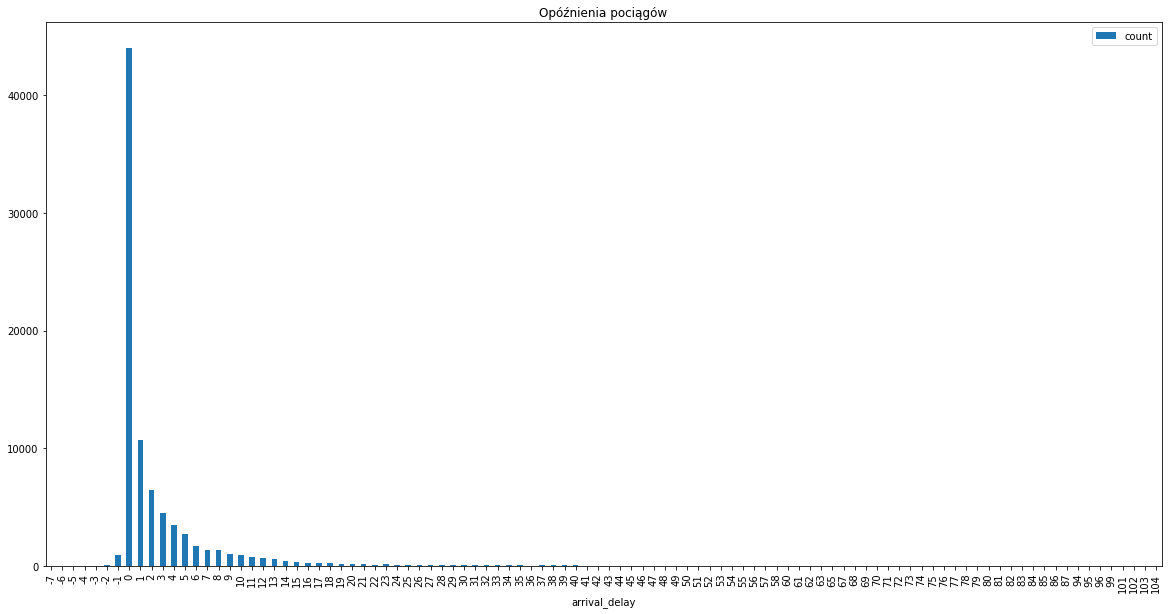

In [34]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,10)

plot_data.plot(kind='bar', x='arrival_delay', title="Opóźnienia pociągów")

In [35]:
plot_data.describe()

,arrival_delay,count
count,100.000000,100.00000
mean,44.050000,849.53000
std,31.200678,4571.28877
min,-7.000000,1.00000
25%,17.750000,3.00000
50%,42.500000,14.00000
75%,70.250000,117.25000
max,104.000000,43990.00000


In [36]:
MODEL.write.csv("trains_sample.csv")

In [37]:
sc.stop()